In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import numpy as np
import numpy.linalg as la
MEPS = np.finfo(float).eps

from scipy.optimize import minimize_scalar

import pandas as pd

from rbf import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


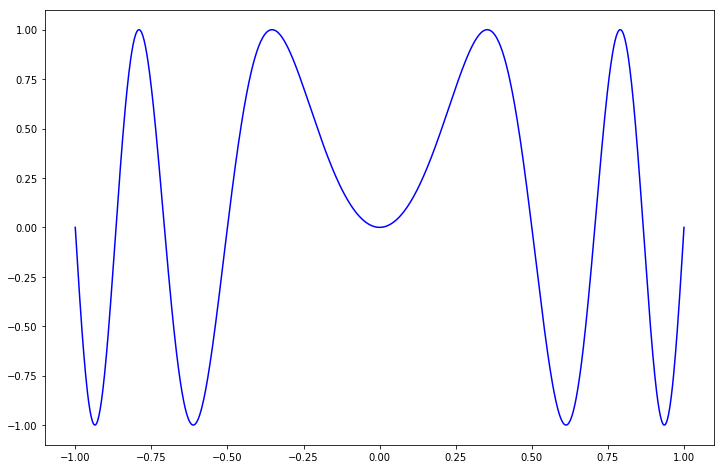

In [2]:
a, b = -1, 1
def foo(x):
    #return (x-0)**2 * x*(x-1)
    #return np.sin(2*np.pi*x)+1
    return np.sin(np.pi* 4*x**2)

xs = np.linspace(a, b, 1000)
plt.figure(figsize=(12,8))
plt.plot(xs, foo(xs),'b-')
plt.show()

In [13]:
def rbf_interp(xs, fs, zs, rbf, eps=1, deg=-1, optimize_shape=False, target_cond=10**12, return_cond=False):
    dist_mat = np.abs(np.subtract.outer(xs,xs))
    if deg < 0:
        P = None
    else:
        P = np.power.outer(xs, np.arange(deg+1) )
    # optimize shape parameter
    if optimize_shape:
        eps = optimize_eps(rbf, dist_mat, P=P, target_cond=target_cond)

    A = rbf(dist_mat, eps)
    if deg < 0:
        AP = A
    else:
        AP = np.block([[A, P],[P.T, np.zeros((deg+1,deg+1))]])

    if return_cond:
        AP_cond = la.cond(AP)
    else:
        AP_cond = None
    
    if deg < 0:
        cs = la.solve(AP, fs)
    else:
        cs = la.solve(AP, np.block([fs, np.zeros(deg+1)]) )
    
    dist_mat = np.abs(np.subtract.outer(zs,xs))
    
    A = rbf(dist_mat, eps)
    if deg < 0:
        P = None
    else:
        P = P = np.power.outer(zs, np.arange(deg+1) )
    if deg < 0:
        AP = A
    else:
        AP = np.block([A, P])
    return AP @ cs, eps, AP_cond

error: 0.000606107
epsilon = 3.53454
cond(A) = 1e+12


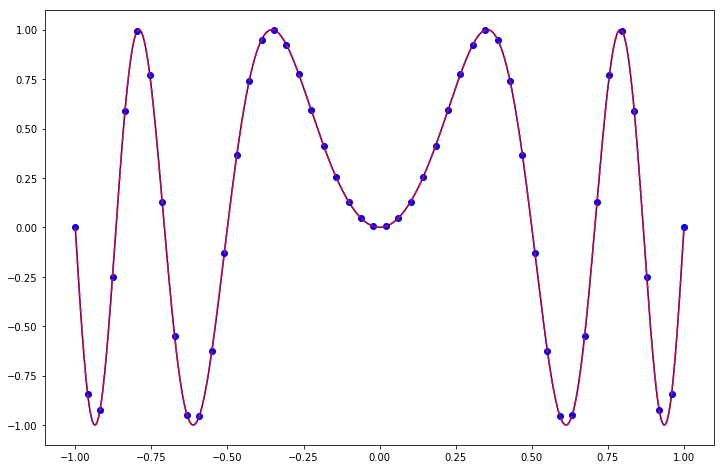

In [14]:
n, m = 50, 1000
deg = 10
rbf_obj = rbf_dict['multiquadric']


rbf = rbf_obj['rbf']
xs = np.linspace(a, b, n)
zs = np.linspace(a, b, m)
us, eps, cond = rbf_interp(xs, foo(xs), zs, rbf, deg=deg, optimize_shape=True, return_cond=True)
err = la.norm(us - foo(zs))/la.norm(foo(zs))

print('error: %g' % err)
print('epsilon = %g' % eps)
print('cond(A) = %g'%cond)

plt.figure(figsize=(12,8))
plt.plot(xs, foo(xs),'bo')
plt.plot(zs, foo(zs), 'b-')
plt.plot(zs, us, 'r--')
plt.show()

In [12]:
degs = range(-1,3)
ns = [256*2**i for i in range(5)]
print(ns)

errors = []
epsilons = []
m = 4000
zs = np.linspace(a, b, m)

for d in degs:
    errors += [[]]
    for n in ns[::-1]:
        print('calculating deg=%d \tn=%d' % (d,n))
        xs = np.linspace(a, b, n)
        if n == ns[-1]:
            us, eps, A_cond = rbf_interp(xs, foo(xs), zs, rbf, deg=d)
            epsilons += [eps]
        else:
            us = rbf_interp(xs, foo(xs), zs, rbf, deg=4, eps=eps)

        err = la.norm(us - foo(zs))/la.norm(foo(zs))
        errors[-1] += [err]

[256, 512, 1024, 2048, 4096]
calculating deg=-1 	n=4096
calculating deg=-1 	n=2048


ValueError: operands could not be broadcast together with shapes (3,) (4000,) 

In [ ]:
plt.figure(figsize=(12,8))
for errs in errors:
    plt.loglog(ns, errs[::-1],'o--')
plt.xticks(ns, ['%d'%n for n in ns])
plt.legend(['deg=%d'%d for d in degs])
plt.show()

In [ ]:
epsilons = [.1, .2, .5, 1, 2, 4, 10]
ns = [8*2**i for i in range(6)]
print(ns)
#d = 0
degs = range(-1, 4)

deg_errors = []
m = 4000
zs = np.linspace(a, b, m)

for d in degs:
    deg_errors += []
    errors = []
    for eps in epsilons:
        errors += [[]]
        for n in ns[::-1]:
            xs = np.linspace(a, b, n)
            us = rbf_interp(xs, foo(xs), zs, rbf, deg=d, eps=eps)

            err = la.norm(us - foo(zs))/la.norm(foo(zs))
            errors[-1] += [err]
    deg_errors += [errors]

In [ ]:
for d, errors in zip(degs, deg_errors):
    plt.figure(figsize=(12,8))
    for errs in errors:
        plt.loglog(ns, errs[::-1],'--')
    plt.legend(['$\\varepsilon = %.2f$' % eps for eps in epsilons])
    plt.title('deg = %d' % d)
    plt.xticks(ns, ns)
    plt.show()

# Optimize submatrix condition number

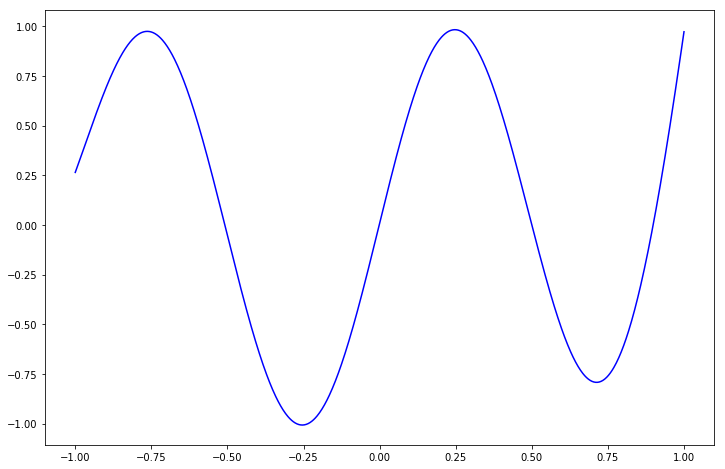

In [5]:
a, b = -1, 1
def foo(x):
    return np.sin(np.pi* 2*x) + (x-.1)*(x+.2)*(x-.5)*(x+.8)

xs = np.linspace(a, b, 1000)
plt.figure(figsize=(12,8))
plt.plot(xs, foo(xs),'b-')
plt.show()

-3.9939201231128774
error: 2.12318e-05


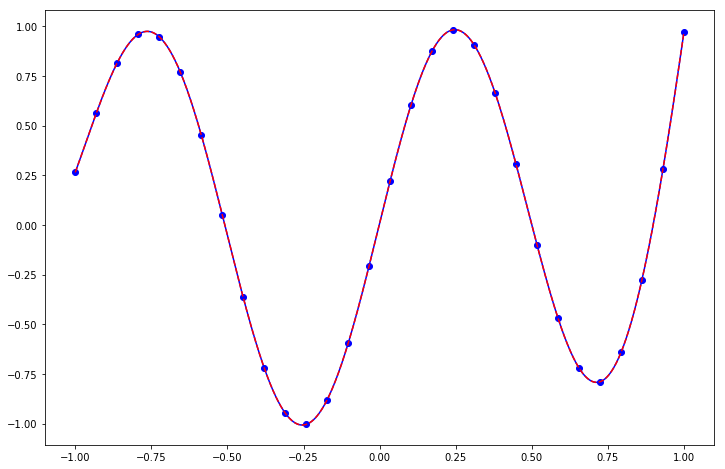

In [8]:
n, m = 30, 1000
deg = 3

xs = np.linspace(a, b, n)
zs = np.linspace(a, b, m)

us = rbf_interp(xs, foo(xs), zs, rbf, deg=deg)
err = la.norm(us - foo(zs))/la.norm(foo(zs))
print('error: %g' % err)

plt.figure(figsize=(12,8))
plt.plot(xs, foo(xs),'bo')
plt.plot(zs, foo(zs), 'b-')
plt.plot(zs, us, 'r--')
plt.show()

In [28]:
degs = range(-1,20)
N = 200
m = 1000

zs = np.linspace(a, b, m)
for d in degs:
    k = d+1
    xs = np.linspace(a, b, N+k)
    len1 = len(xs)
    us = rbf_interp(xs, foo(xs), zs, rbf, deg=-1)
    err = la.norm(us - foo(zs))/la.norm(foo(zs))
    #print('unaugmented error: \t%g' % err )
    err_standard = err
    
    xs = np.linspace(a, b, N)
    len2 = len(xs)
    us = rbf_interp(xs, foo(xs), zs, rbf, deg=d)
    err = la.norm(us - foo(zs))/la.norm(foo(zs))
    #print('augmented error: \t%g' % err )
    err_aug = err
    
    print('\ndeg = %d' % d)
    print('ratio: %g' % (err_aug/err_standard))
    print('error augmented: %g' % err_aug)
    
        


deg = -1
ratio: 1
error augmented: 1.6953e-05

deg = 0
ratio: 0.933896
error augmented: 1.57651e-05

deg = 1
ratio: 1.08075
error augmented: 1.81673e-05

deg = 2
ratio: 0.909621
error augmented: 1.52266e-05

deg = 3
ratio: 1.13127
error augmented: 1.88577e-05

deg = 4
ratio: 1.10319
error augmented: 1.83134e-05

deg = 5
ratio: 0.83537
error augmented: 1.38104e-05

deg = 6
ratio: 0.838814
error augmented: 1.38104e-05

deg = 7
ratio: 0.222809
error augmented: 3.65343e-06

deg = 8
ratio: 0.223716
error augmented: 3.65343e-06

deg = 9
ratio: 0.0328367
error augmented: 5.34086e-07

deg = 10
ratio: 0.032969
error augmented: 5.34086e-07

deg = 11
ratio: 0.00315337
error augmented: 5.08799e-08

deg = 12
ratio: 0.0031659
error augmented: 5.08799e-08

deg = 13
ratio: 0.00021583
error augmented: 3.45495e-09

deg = 14
ratio: 0.000216679
error augmented: 3.45492e-09

deg = 15
ratio: 1.11469e-05
error augmented: 1.77043e-10

deg = 16
ratio: 1.12014e-05
error augmented: 1.77219e-10

deg = 17
ratio: 

In [33]:
def foo(x):
    return np.abs(x)

degs = range(-1,20)
N = 200
m = 1000

zs = np.linspace(a, b, m)
for d in degs:
    k = d+1
    xs = np.linspace(a, b, N+k)
    len1 = len(xs)
    us = rbf_interp(xs, foo(xs), zs, rbf, deg=-1)
    err = la.norm(us - foo(zs))/la.norm(foo(zs))
    #print('unaugmented error: \t%g' % err )
    err_standard = err
    
    xs = np.linspace(a, b, N)
    len2 = len(xs)
    us = rbf_interp(xs, foo(xs), zs, rbf, deg=d)
    err = la.norm(us - foo(zs))/la.norm(foo(zs))
    #print('augmented error: \t%g' % err )
    err_aug = err
    
    print('\ndeg = %d' % d)
    print('ratio: %g' % (err_aug/err_standard))
    print('error augmented: %g' % err_aug)
    


deg = -1
ratio: 1
error augmented: 0.000222175

deg = 0
ratio: 1.04334
error augmented: 0.000222175

deg = 1
ratio: 1.0158
error augmented: 0.000222175

deg = 2
ratio: 1.05899
error augmented: 0.000222176

deg = 3
ratio: 1.03172
error augmented: 0.000222176

deg = 4
ratio: 1.07471
error augmented: 0.000222177

deg = 5
ratio: 1.04774
error augmented: 0.000222177

deg = 6
ratio: 1.0905
error augmented: 0.000222179

deg = 7
ratio: 1.06386
error augmented: 0.000222179

deg = 8
ratio: 1.10637
error augmented: 0.00022218

deg = 9
ratio: 1.08009
error augmented: 0.00022218

deg = 10
ratio: 1.12231
error augmented: 0.000222182

deg = 11
ratio: 1.09643
error augmented: 0.000222182

deg = 12
ratio: 1.13832
error augmented: 0.000222184

deg = 13
ratio: 1.11288
error augmented: 0.000222184

deg = 14
ratio: 1.1544
error augmented: 0.000222187

deg = 15
ratio: 1.12944
error augmented: 0.000222187

deg = 16
ratio: 1.17056
error augmented: 0.000222191

deg = 17
ratio: 1.14611
error augmented: 0.00022

In [32]:
def foo(x):
    return np.abs(x)

def rbf(r, eps):
    return r**3

degs = range(-1,20)
N = 200
m = 1000

zs = np.linspace(a, b, m)
for d in degs:    
    xs = np.linspace(a, b, N)
    len2 = len(xs)
    us = rbf_interp(xs, foo(xs), zs, rbf, deg=d)
    err = la.norm(us - foo(zs))/la.norm(foo(zs))
    #print('augmented error: \t%g' % err )
    err_aug = err
    
    print('\ndeg = %d' % d)
    print('ratio: %g' % (err_aug/err_standard))
    print('error augmented: %g' % err_aug)


deg = -1
ratio: 16412.3
error augmented: 0.000222175

deg = 0
ratio: 16412.3
error augmented: 0.000222175

deg = 1
ratio: 16412.3
error augmented: 0.000222175

deg = 2
ratio: 16412.4
error augmented: 0.000222176

deg = 3
ratio: 16412.4
error augmented: 0.000222176

deg = 4
ratio: 16412.5
error augmented: 0.000222177

deg = 5
ratio: 16412.5
error augmented: 0.000222177

deg = 6
ratio: 16412.6
error augmented: 0.000222179

deg = 7
ratio: 16412.6
error augmented: 0.000222179

deg = 8
ratio: 16412.7
error augmented: 0.00022218

deg = 9
ratio: 16412.7
error augmented: 0.00022218

deg = 10
ratio: 16412.8
error augmented: 0.000222182

deg = 11
ratio: 16412.8
error augmented: 0.000222182

deg = 12
ratio: 16413
error augmented: 0.000222184

deg = 13
ratio: 16413
error augmented: 0.000222184

deg = 14
ratio: 16413.2
error augmented: 0.000222187

deg = 15
ratio: 16413.2
error augmented: 0.000222187

deg = 16
ratio: 16413.5
error augmented: 0.000222191

deg = 17
ratio: 16413.5
error augmented: 0.